In [1]:
PIPELINE_CONTEXT = {"_runtime_context_name": "PIPELINE_CONTEXT", "params": {"n_clusters": "auto", "n_clusters_min": 6, "n_clusters_max": 30, "n_clusters_criterion": "silhouette", "pca_components": "auto", "pca_variance": 0.9, "pca_max_components": 50, "random_state": 42}, "artifacts": {"dir": "/vol/bitbucket/sn1624/data-driven-framework-for-athlete-profiling/artifacts/run_20250819_130446", "processed_data": "/vol/bitbucket/sn1624/data-driven-framework-for-athlete-profiling/artifacts/run_20250819_130446/processed.parquet", "model_file": "/vol/bitbucket/sn1624/data-driven-framework-for-athlete-profiling/artifacts/run_20250819_130446/kmeans_model.joblib", "scaler_file": "/vol/bitbucket/sn1624/data-driven-framework-for-athlete-profiling/artifacts/run_20250819_130446/scaler.joblib", "pca_file": "/vol/bitbucket/sn1624/data-driven-framework-for-athlete-profiling/artifacts/run_20250819_130446/pca.joblib", "cluster_summary": "/vol/bitbucket/sn1624/data-driven-framework-for-athlete-profiling/artifacts/run_20250819_130446/cluster_summary.json", "elbow_plot": "/vol/bitbucket/sn1624/data-driven-framework-for-athlete-profiling/artifacts/run_20250819_130446/elbow_plot.png", "silhouette_plot": "/vol/bitbucket/sn1624/data-driven-framework-for-athlete-profiling/artifacts/run_20250819_130446/silhouette_plot.png", "selection": "/vol/bitbucket/sn1624/data-driven-framework-for-athlete-profiling/artifacts/run_20250819_130446/selection.json"}, "cwd": "/vol/bitbucket/sn1624/data-driven-framework-for-athlete-profiling/pipeline", "data_dir": "/vol/bitbucket/sn1624/data-driven-framework-for-athlete-profiling/data/output_by_college_clean"}

**Pipeline Context**

In [2]:
try:
    ctx = PIPELINE_CONTEXT
except NameError:
    import os
    ctx = {
        "params": {},
        "artifacts": {
            "dir": "artifacts",
            "processed_data": "artifacts/processed.parquet",
            "model_file": "artifacts/kmeans_model.joblib",
            "scaler_file": "artifacts/scaler.joblib",
            "pca_file": "artifacts/pca.joblib",
            "cluster_summary": "artifacts/cluster_summary.json",
            "elbow_plot": "artifacts/elbow_plot.png",
            "silhouette_plot": "artifacts/silhouette_plot.png",
            "selection": "artifacts/selection.json",
        },
        "data_dir": "data",
    }

from pathlib import Path
import json

P = ctx.get("params", {})
PATHS = ctx.get("artifacts", {})
DATA_DIR = ctx.get("data_dir", "data")
Path(PATHS["dir"]).mkdir(parents=True, exist_ok=True)

def save_json(obj, path):
    Path(path).parent.mkdir(parents=True, exist_ok=True)
    with open(path, "w") as f:
        json.dump(obj, f, indent=2, default=float)

def load_json(path, default=None):
    p = Path(path)
    if p.exists():
        return json.loads(p.read_text())
    return {} if default is None else default


**Imports**


In [3]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
import itertools
from scipy.optimize import linear_sum_assignment
from tqdm.auto import tqdm
import joblib

/vol/bitbucket/sn1624/data-driven-framework-for-athlete-profiling/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**Data Loading**

In [4]:
df_pca = pd.read_csv('df_pca.csv', index_col=0)
print("df_pca shape:", df_pca.shape)

df_full = pd.read_csv('player_features_cleaned.csv')
print("player_features_cleaned shape:", df_full.shape)

df_clean = pd.read_csv('df_clean.csv')
print("df_clean shape:", df_clean.shape)

df_pca shape: (1181, 12)
player_features_cleaned shape: (2065, 80)
df_clean shape: (1181, 80)


In [5]:
print("df_pca head:")
print(df_pca.head())

df_pca head:
        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0  3.510573  2.778802  3.381575  3.219243  0.589782  0.910910  1.523564   
1  4.064745  1.931403 -0.670924 -1.330892  1.171576 -2.402895  1.388396   
2  4.740483 -2.892328 -2.160327 -0.595854  0.171048  0.055935 -1.446789   
3  0.504668 -0.620421  4.028174  0.814864 -1.035240 -0.519205  1.210944   
4 -0.013385 -4.694552 -1.805144 -2.226669 -0.660436 -0.036662  0.330226   

        PC8       PC9      PC10  player_number_ind      player_ind  
0 -0.618914  0.182938  0.744980                  4   Kayla Hoohuli  
1  0.734487  0.123666 -0.086453                  5   Tiahana Mills  
2 -0.285816  1.006014  0.711530                 24  Crystal Porter  
3  0.085385  0.125598 -0.575061                 31     Emily Weber  
4 -0.977356  0.545615 -1.062277                 20   Jasmine Mungo  


In [6]:
# pull the PC columns into a NumPy array
pc_cols   = [c for c in df_pca.columns if c.startswith('PC')]
X_cluster = df_pca[pc_cols].values


In [7]:
print(df_clean.columns)

Index(['college', 'season', 'player_number_ind', 'player_ind', 'gp_ind',
       'gs_ind', 'minutes_tot_ind', 'scoring_pts_ind', 'rebounds_tot_ind',
       'ast_ind', 'stl_ind', 'blk_ind', 'to_ind', 'pts_per40', 'reb_per40',
       'ast_per40', 'stl_per40', 'blk_per40', 'to_per40', 'eFG_pct', 'TS_pct',
       'USG_pct', 'ORB_pct', 'DRB_pct', 'AST_pct', 'AST_per_TO',
       '3pt_3pt_pct_ind', 'three_per40', 'threeA_per40', 'three_per100',
       'threeA_rate', 'DRCR', 'STL_TO_ratio', 'def_stops_per100', 'DPMR',
       'TUSG_pct', 'Gravity', 'PPT', 'Spacing', 'Assist_to_Usage', 'APC',
       'PEF', 'OEFF', 'TOV_pct', 'SEM', 'PEI', 'BoxCreation', 'OLI', 'IPM',
       'threeA_per100', '2pt_pct', 'FTr', 'PPP', 'possessions',
       'scoring_pts_per100', 'ast_per100', 'rebounds_tot_per100', 'stl_per100',
       'blk_per100', 'to_per100', 'mins_per_game', 'pts_per_game',
       'ast_per_game', 'reb_per_game', 'stl_per_game', 'blk_per_game',
       'to_per_game', 'scoring_pts_share', 'ast_share

**K-MEANS CLUSTERING**



In [8]:
# K-Means Elbow & Silhouette Sweep

ks = list(range(6, 30))
inertias = []
sil_scores = []

for k in ks:
    # fit KMeans
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_cluster)
    
    # record inertia (sum of squared distances to centroids)
    inertias.append(km.inertia_)
    
    # record silhouette
    sil = silhouette_score(X_cluster, labels) if k > 1 else np.nan
    sil_scores.append(sil)

# Plot inertia (elbow)
plt.figure(figsize=(8,4))
plt.plot(ks, inertias, marker='o', linestyle='-')
plt.xlabel("Number of clusters k")
plt.ylabel("Inertia (SSE)")
plt.title("K-Means Elbow Plot")
plt.tight_layout()
plt.savefig(PATHS["elbow_plot"], dpi=144)
plt.close()
plt.show()



# Plot silhouette
plt.figure(figsize=(8,4))
plt.plot(ks, sil_scores, marker='o', linestyle='-')
plt.xlabel("Number of clusters k")
plt.ylabel("Average Silhouette Score")
plt.title("K-Means Silhouette vs. k")
plt.tight_layout()
plt.savefig(PATHS["silhouette_plot"], dpi=144)
plt.close()
plt.show()



best_k = ks[np.argmax(sil_scores)]
print(f"Best k by silhouette score: {best_k} with score {max(sil_scores):.4f} ")

selected = load_json(PATHS["selection"], default={})
selected["best_k"] = int(best_k)
save_json(selected, PATHS["selection"])
print("Saved best_k to:", PATHS["selection"], "->", selected["best_k"])

Best k by silhouette score: 6 with score 0.1426 
Saved best_k to: /vol/bitbucket/sn1624/data-driven-framework-for-athlete-profiling/artifacts/run_20250819_130446/selection.json -> 6



best_k=6  missing labels? 0
k=6, silhouette = 0.102
Centroids:
         pts_per40  eFG_pct  AST_per_TO  reb_per40  stl_per40  blk_per40
cluster                                                                 
0            -1.38    -1.15       -0.77       0.68      -0.60       1.22
1             0.43     0.40        0.52      -0.28       0.62      -0.29
2             0.62     0.08       -0.33       0.38       0.97      -0.17
3            -0.38     0.08        2.21      -0.57       0.73      -0.55
4            -1.86    -0.98        1.01      -0.91       0.34      -0.62
5             0.57     0.20       -0.02       1.33       1.25       0.50
6             0.06    -0.24       -0.84       0.22      -0.81       0.03
7            -0.07     0.74       -0.09      -0.74      -0.47      -0.37
8            -0.16     0.31        0.54      -1.02      -1.04      -0.40
9             0.92     1.05       -0.19       0.08      -0.24       0.11
10           -1.49     0.27        3.66      -0.65       0.0

Saved: /vol/bitbucket/sn1624/data-driven-framework-for-athlete-profiling/artifacts/run_20250819_130446/cluster_summary.json


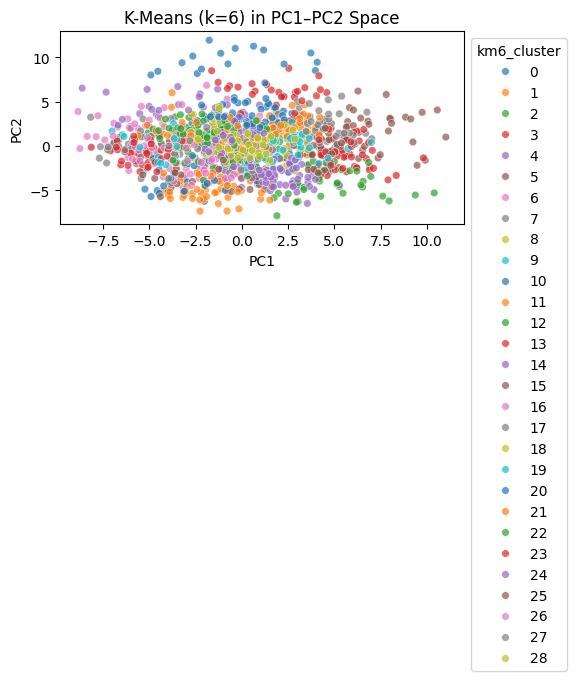

In [9]:
# K-Means Clustering

# reset both indexes to simple RangeIndex so positions match
df_clean = df_clean.reset_index(drop=True)
df_pca   = df_pca.reset_index(drop=True)

# make sure we have our PC matrix
X_cluster = df_pca[pc_cols].values

# stats we'll profile
key_stats = ['pts_per40','eFG_pct','AST_per_TO','reb_per40','stl_per40','blk_per40']


col = f'km{best_k}_cluster'

# fit & predict
kmeans     = KMeans(n_clusters=best_k, random_state=42, n_init=10)
labels = km.fit_predict(X_cluster)

# positional assignment (no alignment)
df_pca[col]   = labels
df_clean[col] = labels  # safe: both have same length & index

# check no NaNs 
n_missing = df_clean[col].isna().sum()
print(f"\n{best_k=}  missing labels? {n_missing}")

# silhouette
sil = silhouette_score(X_cluster, labels)
print(f"k={best_k}, silhouette = {sil:.3f}")

# centroids on your key stats
cent = (
    df_clean
    .groupby(col)[key_stats]
    .mean()
    .round(2)
    .rename_axis('cluster')
)
print("Centroids:")
print(cent.to_string())

# Save Trained Artifacts
# Save trained KMeans model
joblib.dump(kmeans, PATHS["model_file"])
print("Saved model to:", PATHS["model_file"])

# Save processed data with cluster labels
df_out = df_clean.copy()
df_out['cluster'] = labels   # generic name for dashboard
df_out.to_parquet(PATHS["processed_data"])
print("Wrote processed data with clusters to:", PATHS["processed_data"])

# Save summary JSON
summary = {
    "selected": {
        "n_clusters": int(best_k),
        "pca_components": int(load_json(PATHS["selection"]).get("n_pca", 0))
    },
    "scores": {
        "silhouette": float(sil)
    },
    "cluster_sizes": {str(i): int((labels == i).sum()) for i in range(best_k)}
}
save_json(summary, PATHS["cluster_summary"])
print("Saved:", PATHS["cluster_summary"])

# scatter in PC1–PC2
plt.figure(figsize=(6,5))
sns.scatterplot(
    x=df_pca['PC1'].values,
    y=df_pca['PC2'].values,
    hue=labels,
    palette='tab10',
    s=30,
    alpha=0.7
)
plt.title(f"K-Means (k={best_k}) in PC1–PC2 Space")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title=col, bbox_to_anchor=(1,1))
plt.tight_layout()
plt.show()



**ARCHETYPE MATCHING**

In [10]:
archetypes = {
    "Efficient Spot-Up Shooter": [
        ("eFG_pct", 1),
        ("3pt_3pt_pct_ind", 1),
        ("PPP", 1),
        ("FTr", 1),
        ("Spacing", 1),
    ],
    "Primary Creator / High-Usage Scorer": [
        ("USG_pct", 1),
        ("AST_per_TO", 1),
        ("pts_per40", 1),
        ("eFG_pct", 1),
        ("PPP", 1),
    ],
    "Defensive Ballhawk": [
        ("stl_per40", 1),
        ("STL_pct", 1),
        ("USG_pct", 1),
        ("AST_per_TO", 1),
        ("def_stops_per100", 1),
    ],
    "Two-Way Guard": [
        ("stl_per40", 1),
        ("PPT", 1),
        ("USG_pct", 1),
        ("AST_per_TO", 1),
        ("AST_pct", 1),
    ],
    "Versatile Facilitator / Combo Big": [
        ("AST_per_TO", 1),
        ("reb_per40", 1),
        ("blk_per40", 1),
        ("DPMR", 1),
        ("FTr", 1),
    ],
    "Rim Protector / Rebounding Big": [
        ("blk_per40", 1),
        ("DPMR", 1),
        ("def_stops_per100", 1),
        ("ORB_pct", 1),
        ("DRB_pct", 1),
    ],
    "Efficient Finisher / Low-Usage Big": [
        ("FTr", 1),
        ("eFG_pct", 1),
        ("ORB_pct", 1),
        ("PPP", 1),
        ("TS_pct", 1),
    ],
    "Glue Role Player / Hustle Forward": [
        ("reb_per40", 1),
        ("blk_per40", 1),
        ("stl_per40", 1),
        ("def_stops_per100", 1),
        ("game_score_per40", 1),
    ],
    "High-Usage Volume Big / Post Scorer": [
        ("USG_pct", 1),
        ("pts_per40", 1),
        ("FTr", 1),
        ("eFG_pct", 1),
        ("ORB_pct", 1),
    ],
    "Shooting-Creative Guard": [
        ("3pt_3pt_pct_ind", 1),
        ("AST_per_TO", 1),
        ("USG_pct", 1),
        ("eFG_pct", 1),
        ("PPP", 1),
    ],
    "Floor-Spacer Stretch Four": [
        ("3pt_3pt_pct_ind", 1),
        ("eFG_pct", 1),
        ("Spacing", 1),
        ("FTr", 1),
        ("DRB_pct", 1),
    ],
    "Pick-and-Roll Ball Handler": [
        ("AST_per_TO", 1),
        ("USG_pct", 1),
        ("AST_pct", 1),
        ("TOV_pct", -1),
        ("pts_per40", 1),
    ],
    "Roll Man / Screen Finisher": [
        ("ORB_pct", 1),
        ("FTr", 1),
        ("blk_per40", 1),
        ("reb_per40", 1),
        ("PPP", 1),
    ],
    "Isolation Scorer": [
        ("USG_pct", 1),
        ("pts_per40", 1),
        ("eFG_pct", 1),
        ("TOV_pct", -1),
        ("FTr", 1),
    ],
    "Transition Creator": [
        ("pts_per40", 1),
        ("AST_per_TO", 1),
        ("stl_per40", 1),
        ("USG_pct", 1),
        ("possessions", 1),
    ],
    "Pass-First Point Guard / Floor General": [
        ("AST_per_TO", 1),
        ("AST_pct", 1),
        ("TOV_pct", -1),
        ("USG_pct", 1),
        ("stl_per40", 1),
    ],
    "Perimeter Shutdown Defender": [
        ("def_stops_per100", 1),
        ("DPMR", 1),
        ("stl_per40", 1),
        ("STL_TO_ratio", 1),
        ("DRB_pct", 1),
    ],
    "Secondary Creator / Off-Ball Facilitator": [
        ("AST_per_TO", 1),
        ("BoxCreation", 1),
        ("Spacing", 1),
        ("PPP", 1),
        ("3pt_3pt_pct_ind", 1),
    ],
    "Slasher / Cutter": [
        ("FTr", 1),
        ("pts_per40", 1),
        ("stl_per40", 1),
        ("AST_per_TO", 1),
        ("eFG_pct", 1),
    ],
    "Second-Chance Specialist": [
        ("ORB_pct", 1),
        ("reb_per40", 1),
        ("pts_per40", 1),
        ("PPP", 1),
        ("game_score_per40", 1),
    ],
    "Playmaking Wing": [
        ("AST_per_TO", 1),
        ("USG_pct", 1),
        ("3pt_3pt_pct_ind", 1),
        ("stl_per40", 1),
        ("PPP", 1),
    ],
    "Gravity/Space Creator": [
        ("Gravity", 1),
        ("Spacing", 1),
        ("threeA_rate", 1),
        ("3pt_3pt_pct_ind", 1),
        ("PPT", 1),
    ],
    "Two-Way Wing": [
        ("eFG_pct", 1),
        ("def_stops_per100", 1),
        ("stl_per40", 1),
        ("reb_per40", 1),
        ("USG_pct", 1),
    ],
    "Corner Specialist": [
        ("3pt_3pt_pct_ind", 1),
        ("Spacing", 1),
        ("eFG_pct", 1),
        ("PPT", 1),
        ("PPP", 1),
    ],
    "Deep Range Specialist": [
        ("3pt_3pt_pct_ind", 1),
        ("eFG_pct", 1), 
        ("Gravity", 1),
        ("threeA_rate", 1),
        ("Spacing", 1),
    ],
    "Floor General": [
        ("AST_per_TO", 1),
        ("AST_pct", 1),
        ("USG_pct", 1),
        ("Spacing", 1),
        ("TOV_pct", -1),
    ],
    "Screen Setter / Roll-Pop Facilitator": [
        ("BoxCreation", 1),
        ("Spacing", 1),
        ("ORB_pct", 1),
        ("AST_per_TO", 1),
        ("FTr", 1),
    ],
    "Off-Ball Movement Creator": [
        ("Spacing", 1),
        ("BoxCreation", 1),
        ("3pt_3pt_pct_ind", 1),
        ("AST_per_TO", 1),
        ("PPP", 1),
    ],
    "Volume Distributor": [
        ("AST_pct", 1),
        ("AST_per_TO", 1),
        ("USG_pct", 1),
        ("pts_per40", 1),
        ("TOV_pct", -1),
    ],
    "Effort Defensive Role Player": [
        ("stl_per40", 1),
        ("reb_per40", 1),
        ("def_stops_per100", 1),
        ("DPMR", 1),
        ("min_share", -1),
    ],
    "Low-Usage Secure Role Player": [
        ("TOV_pct", -1),
        ("min_share", -1),
        ("possessions", -1),
        ("def_stops_per100", 1),
        ("reb_per40", 1),
    ],
    "Offensive Liability / Role Defensive Specialist": [
        ("pts_per40", -1),
        ("eFG_pct", -1),
        ("TS_pct", -1),
        ("PPP", -1),
        ("def_stops_per100", 1),  
        ("DPMR", 1),
    ],
    "Roll Man / Screen Finisher": [
        ("reb_per40", 1),
        ("FTr", 1),
        ("threeA_rate", -1),
        ("reb_per40", 1),
        ("Spacing", -1),
],
"Non-Impact Role Player": [
    ("pts_per40", -1),
    ("eFG_pct", -1),
    ("TS_pct", -1),
    ("PPP", -1),
    ("game_score_per40", -1),
],

}


In [11]:
cluster_col   = f'km{best_k}_cluster'
cluster_labels = np.sort(df_clean[cluster_col].unique())

# Collect the metrics we actually need and z-score them (vectorized)
all_metrics = sorted({m for lst in archetypes.values() for (m, _) in lst})
present_metrics = [m for m in all_metrics if m in df_clean.columns]

X = df_clean[present_metrics].astype(float).copy()
col_means = X.mean(axis=0, skipna=True)
X = X.fillna(col_means)
col_stds = X.std(axis=0, ddof=0).replace(0.0, 1.0)  # avoid div-by-zero
Z = (X - col_means) / col_stds  # global z-score

# Cluster centroids (mean z-score per metric)
# Use the series version of groupby to avoid adding cluster column to Z
cluster_centroids = Z.groupby(df_clean[cluster_col]).mean()   # shape: (n_clusters, n_metrics)
cluster_centroids = cluster_centroids.reindex(index=cluster_labels)

# Build a rectangular score matrix for all clusters × all archetypes (vectorized)
def archetype_weights(n, base=0.5):
    # decreasing geometric weights from most-important → least-important
    raw = np.array([base**i for i in range(n)][::-1], dtype=float)
    return raw / raw.sum()

arch_names = list(archetypes.keys())
score_matrix = np.full((len(cluster_labels), len(arch_names)), -1e3, dtype=float)  # default if no overlap

metrics_cols = cluster_centroids.columns

for j, arch in enumerate(arch_names):
    feats = [m for m, _ in archetypes[arch] if m in metrics_cols]
    if not feats:
        continue
    # indices in the archetype's list that actually exist
    idxs_in_arch = [i for i, (m, _) in enumerate(archetypes[arch]) if m in metrics_cols]
    # weight mask (renormalized over present features)
    w_full = archetype_weights(len(archetypes[arch]))
    w = w_full[idxs_in_arch]
    w = w / w.sum()

    # signs aligned to feats
    signs = np.array([s for (m, s) in archetypes[arch] if m in metrics_cols], dtype=float)
    # Z-scores for all clusters over these feats
    C = cluster_centroids.loc[:, feats].to_numpy()  # shape: (n_clusters, len(feats))
    # weighted sum per cluster
    # multiply by sign (direction) then dot with weights
    scores = (C * signs) @ w
    score_matrix[:, j] = scores

# Solve one rectangular assignment: each cluster maps to a unique archetype
# We want to maximize score, so minimize negative score
cost = -score_matrix
row_ind, col_ind = linear_sum_assignment(cost)  # works with rectangular matrices

best_mapping = {int(cluster_labels[r]): arch_names[c] for r, c in zip(row_ind, col_ind)}
best_total   = score_matrix[row_ind, col_ind].sum()

print("Best total score:", best_total)
print("Cluster → Archetype")
for cl in cluster_labels:
    arch = best_mapping.get(int(cl), None)
    print(f"{cl}: {arch}")

# Report confidence (row-wise margin between best and second-best)
row_best = score_matrix.max(axis=1)
row_second = np.partition(score_matrix, -2, axis=1)[:, -2]
confidence = {int(cluster_labels[i]): float(row_best[i] - row_second[i]) for i in range(len(cluster_labels))}

print("\nConfidence margins:")
for cl in cluster_labels:
    print(f"{cl}: {confidence[int(cl)]:.3f}")


Best total score: 26.59467888203475
Cluster → Archetype
0: Roll Man / Screen Finisher
1: Perimeter Shutdown Defender
2: Pass-First Point Guard / Floor General
3: Off-Ball Movement Creator
4: Screen Setter / Roll-Pop Facilitator
5: Rim Protector / Rebounding Big
6: Isolation Scorer
7: Floor General
8: Deep Range Specialist
9: Primary Creator / High-Usage Scorer
10: Two-Way Guard
11: Versatile Facilitator / Combo Big
12: Non-Impact Role Player
13: Defensive Ballhawk
14: High-Usage Volume Big / Post Scorer
15: Glue Role Player / Hustle Forward
16: Effort Defensive Role Player
17: Transition Creator
18: Low-Usage Secure Role Player
19: Offensive Liability / Role Defensive Specialist
20: Secondary Creator / Off-Ball Facilitator
21: Corner Specialist
22: Second-Chance Specialist
23: Volume Distributor
24: Efficient Spot-Up Shooter
25: Efficient Finisher / Low-Usage Big
26: Gravity/Space Creator
27: Playmaking Wing
28: Pick-and-Roll Ball Handler

Confidence margins:
0: 0.226
1: 0.191
2: 0.276

In [12]:
# # Build a DataFrame view of the score matrix (handles both numpy or DataFrame cases)
# try:
#     score_df = score_matrix.copy()  # if it's already a DataFrame
#     _ = score_df.columns  # will error if not a DataFrame
# except Exception:
#     score_df = pd.DataFrame(score_matrix, index=cluster_labels, columns=arch_names)

# # Compute 0–100% match scores for the chosen mapping
# assigned = []
# for cl in cluster_labels:
#     arch = best_mapping[int(cl)]
#     raw = float(score_df.at[cl, arch])
#     # Perfect = 1.0 (weighted sum over present features, each at +1σ after sign)
#     pct = float(np.clip(raw, 0.0, 1.0)) * 100.0
#     assigned.append({
#         "cluster":    int(cl),
#         "archetype":  arch,
#         "raw_score":  raw,
#         "match_%":    f"{pct:.1f}%"
#     })

# print("\nCluster → Archetype (with match % of a perfect 1σ fit):")
# display(pd.DataFrame(assigned).sort_values("cluster"))


In [13]:
# Ensure score_df exists
try:
    score_df = score_df  # already set by previous cell
except NameError:
    try:
        score_df = score_matrix.copy()
        _ = score_df.columns
    except Exception:
        score_df = pd.DataFrame(score_matrix, index=cluster_labels, columns=arch_names)

row_labels = list(score_df.index)
col_labels = list(score_df.columns)

assigned = []
for cl in row_labels:
    icl = int(cl)
    arch = best_mapping.get(icl)
    if arch is None:
        # belt-and-braces fallback if something slipped through
        j = int(np.nanargmax(score_df.loc[cl].values))
        arch = col_labels[j]
        best_mapping[icl] = arch
    raw = float(score_df.loc[cl, arch])
    pct = float(np.clip(raw, 0.0, 1.0)) * 100.0
    assigned.append({
        "cluster":   icl,
        "archetype": arch,
        "raw_score": raw,
        "match_%":   f"{pct:.1f}%"
    })

print("\nCluster → Archetype (with match % of a perfect 1σ fit):")
display(pd.DataFrame(assigned).sort_values("cluster"))



Cluster → Archetype (with match % of a perfect 1σ fit):


,cluster,archetype,raw_score,match_%
0,0,Roll Man / Screen Finisher,0.857673,85.8%
1,1,Perimeter Shutdown Defender,0.665893,66.6%
2,2,Pass-First Point Guard / Floor General,0.693684,69.4%
3,3,Off-Ball Movement Creator,0.710136,71.0%
4,4,Screen Setter / Roll-Pop Facilitator,0.579438,57.9%
5,5,Rim Protector / Rebounding Big,1.401272,100.0%
6,6,Isolation Scorer,0.078582,7.9%
7,7,Floor General,1.203661,100.0%
8,8,Deep Range Specialist,1.388844,100.0%
9,9,Primary Creator / High-Usage Scorer,0.942244,94.2%
